# MA Strategy with Volatility Filter

In [53]:
# auto reload
%load_ext autoreload
%autoreload 2

# Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import core_metrics, file_exports, strategies

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
from strategies import ma_volatility_filter

In [55]:
# running the strategy
# constants
investment_amount = 10000
test_data = pd.read_csv("../data/processed/training_data_70.csv")
short_ma = 20
long_ma = 50
threshold = 0.75
result = ma_volatility_filter(investment_amount, test_data, short_ma, long_ma, threshold, transaction_costs=0.001, slippage=0.0005)

In [56]:
result.tail()

,Open,High,Low,Close,Volume,MA_short,MA_long,TR,ATR,ATR_pct,...,position,trade_cost,market_ret,strategy_ret,strategy_ret_net,market_ret_net,cumulative_market,cumulative_strategy,portfolio_value,market_portfolio_value
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-01,374.407243,378.114230,371.691310,377.771179,78740100,395.322696,381.919351,6.422920,6.352458,0.016816,...,0.0,0.0,0.003138,0.0,0.0,0.003138,2.214502,1.530178,15301.78311,22145.024005
2022-09-02,381.449500,382.669283,371.967569,373.787720,99632100,394.311128,382.189609,10.701714,6.932358,0.018546,...,0.0,0.0,-0.010545,-0.0,-0.0,-0.010545,2.191151,1.530178,15301.78311,21911.512793
2022-09-06,374.635883,375.579301,370.147465,372.377380,76637400,393.251915,382.202568,5.431836,6.732289,0.018079,...,0.0,0.0,-0.003773,-0.0,-0.0,-0.003773,2.182884,1.530178,15301.78311,21828.838411
2022-09-07,372.062901,379.839031,371.843739,379.067139,70964200,392.605333,382.377722,7.995292,6.900689,0.018204,...,0.0,0.0,0.017965,0.0,0.0,0.017965,2.222099,1.530178,15301.78311,22220.993415
2022-09-08,376.789646,382.002292,375.579372,381.544891,80821700,391.670963,382.753760,6.422920,6.836987,0.017919,...,0.0,0.0,0.006536,0.0,0.0,0.006536,2.236624,1.530178,15301.78311,22366.239785


In [57]:
# export as csv in the data file
csv_name = "ma_volatility_filter.csv"
output_folder = "../data/strategy_results/"

from file_exports import export_file
export_file(csv_name, output_folder, result)

Exported data as file ../data/strategy_results/ma_volatility_filter.csv successfully.


In [58]:
# prelim test on final strategy portfolio value given varying threshold levels
thresholds = [0.5, 0.6, .7, .75, .8, .85, .9, .95]
for t in thresholds:
    res = ma_volatility_filter(investment_amount, test_data, short_ma, long_ma, t, transaction_costs=0.001, slippage=0.0005)
    print(f"Threshold = {t}, final value = {res['portfolio_value'].iloc[-1]}")

Threshold = 0.5, final value = 11751.553261201878
Threshold = 0.6, final value = 12075.61808358983
Threshold = 0.7, final value = 13116.749608635684
Threshold = 0.75, final value = 15301.783110238099
Threshold = 0.8, final value = 15301.783110238099
Threshold = 0.85, final value = 14892.372087324748
Threshold = 0.9, final value = 14892.372087324748
Threshold = 0.95, final value = 14892.372087324748


## Core Performance Metrics
To evaluate the basline strategy, we will perform the following tests.


### 1. Profit & Loss Metrics
Let's examine the returns and P&L of the strategy and market portfolios, considering transaction cost and slippage amounts as defined above.

Final portfolio value: 15301.783110238099 on 2022-09-08 00:00:00
Strategy returned 53.01783110238099% from 2015-01-02 00:00:00 to 2022-09-08 00:00:00
Market returned 123.66239785226219 from 2015-01-02 00:00:00 to 2022-09-08 00:00:00

Annualized across 7.6824 years: 
MA Strategy returned 5.6933% per year
Buy & Hold the market returned 11.0467% per year


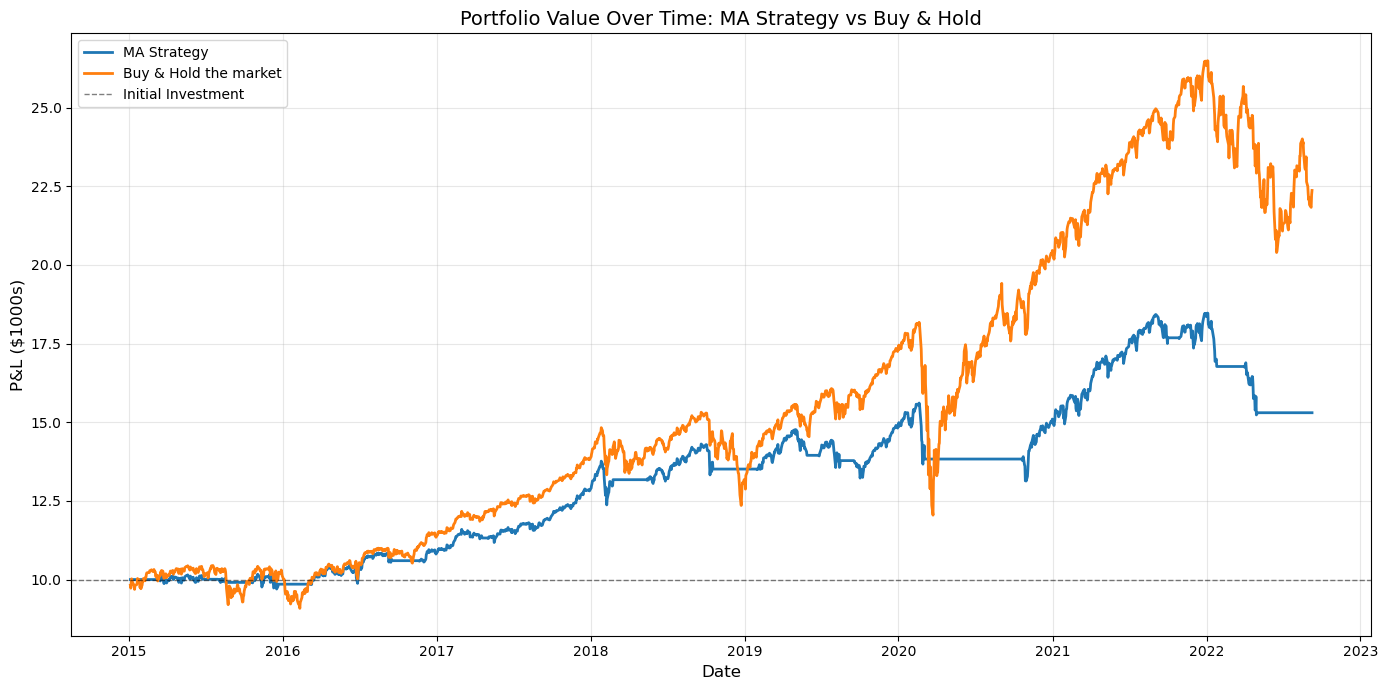

In [59]:
from core_metrics import pnl

graph_title = 'Portfolio Value Over Time: MA Strategy vs Buy & Hold'
strategy_name = "MA Strategy"
benchmark_name = "Buy & Hold the market"

result, strategy_annual_return, market_annual_return = pnl(result, investment_amount, strategy_name, benchmark_name, graph_title)

### 2. Performance Ratios

In [60]:
from core_metrics import performance_ratios

perf_ratios = performance_ratios(result)

print("WITHOUT transaction costs...")
print(f"Sharpe Ratio: {perf_ratios['sharpe ratio']}")
print(f"Information Ratio: {perf_ratios['information ratio']}")
print(f"Sortino Ratio: {perf_ratios['sortino ratio']} \n")

print("WITH transaction costs...")
print(f"Sharpe Ratio: {perf_ratios['sharpe with costs']}")
print(f"Information Ratios: {perf_ratios['information ratio with costs']}")
print(f"Sortino Ratio: {perf_ratios['sortino ratio with costs']}")


WITHOUT transaction costs...
Sharpe Ratio: 0.43615546612120276
Information Ratio: 10.028151831029456
Sortino Ratio: 6.474149248877736 

WITH transaction costs...
Sharpe Ratio: 0.36936612254008167
Information Ratios: 10.020334280220377
Sortino Ratio: 5.477636837302676


In [61]:
from core_metrics import risk_metrics

risks = risk_metrics(result)
print(f"Max Drawdown: {(100 * risks['max_drawdown']):.2f}%")
print(f"Average Drawdown: {(100 * risks['avg_drawdown']):.2f}%")
print(f"Max Drawdown Duration: {(risks['max_dd_duration']):.2f} days")
print(f"Average Drawdown Duration: {(risks['avg_dd_duration']):.2f} days")
print(f"Volatility: {(100 * risks['volatility']):.2f}%")

Max Drawdown: -17.52%
Average Drawdown: -3.98%
Max Drawdown Duration: 243.00 days
Average Drawdown Duration: 16.75 days
Volatility: 9.98%


### 4. Trade Statistics

In [67]:
from core_metrics import trade_statistics

trade_stats = trade_statistics(result)
print(f"Total Number of Trades: {(result['position'] != 0).sum()}")
print(f"Average Holding Periods: {trade_stats['avg_holding_period']}")
print(f"Win Rate: {trade_stats['win_rate']}")
print(f"Win-Loss Ratio: {trade_stats['win_loss_ratio']}")
print(f"Profit Factor (gross profit/gross loss): {trade_stats['profit_factor']}")


Total Number of Trades: 33
Average Holding Periods: 110.5
Win Rate: 0.625
Win-Loss Ratio: inf
Profit Factor (gross profit/gross loss): 4.369487791692212


### 5. Strategy Beta to Benchmark

In [64]:
from core_metrics import find_alpha, calmar_ratio, find_beta

beta = find_beta(result, result.index[0], result.index[-1])
print(f'Beta: {beta}')
alpha = find_alpha(result, strategy_annual_return, market_annual_return)
print(f'Alpha: {alpha}')
calmar = calmar_ratio(strategy_annual_return, risks['max_drawdown'])
print(f'Calmar Ratio: {calmar:.2f}')

Beta: 0.29621723246759335
Alpha: 0.010084881077997987
Calmar Ratio: 0.32


### 5. Consistency of Returns

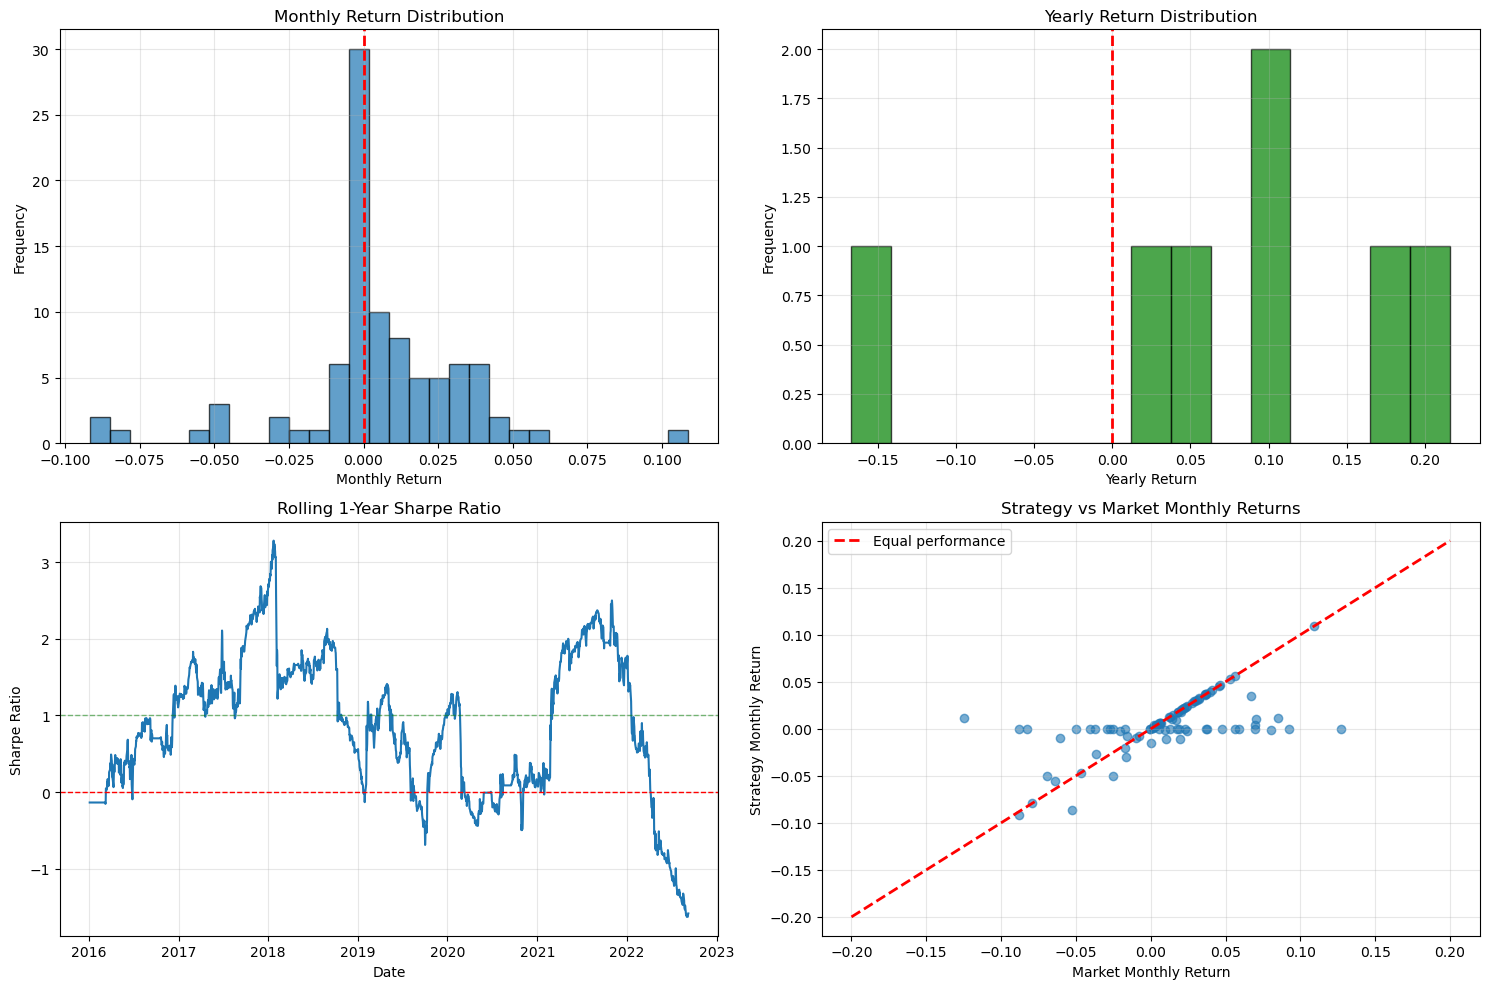

Percentage of Positive Months: 50.54%
Average Monthly Return: 0.50%
Median Monthly Return: 0.12%
Standard Deviation of Monthly Returns: 2.88%
Percentage of Positive Years: 75.00%
Average Yearly Return: 7.17%
Median Yearly Return: 9.71%


In [65]:
from core_metrics import consistency

window = 252 # trading days (for rolling sharpe)
consistency = consistency(result, window)

print(f"Percentage of Positive Months: {consistency['pct_positive_months']:.2%}")
print(f"Average Monthly Return: {consistency['avg_monthly_return']:.2%}")
print(f"Median Monthly Return: {consistency['median_monthly_return']:.2%}")
print(f"Standard Deviation of Monthly Returns: {consistency['std_monthly_return']:.2%}")

print(f"Percentage of Positive Years: {consistency['pct_positive_years']:.2%}")
print(f"Average Yearly Return: {consistency['avg_yearly_return']:.2%}")
print(f"Median Yearly Return: {consistency['median_yearly_return']:.2%}")


### 6. Sensitivity of Returns to Transaction Costs

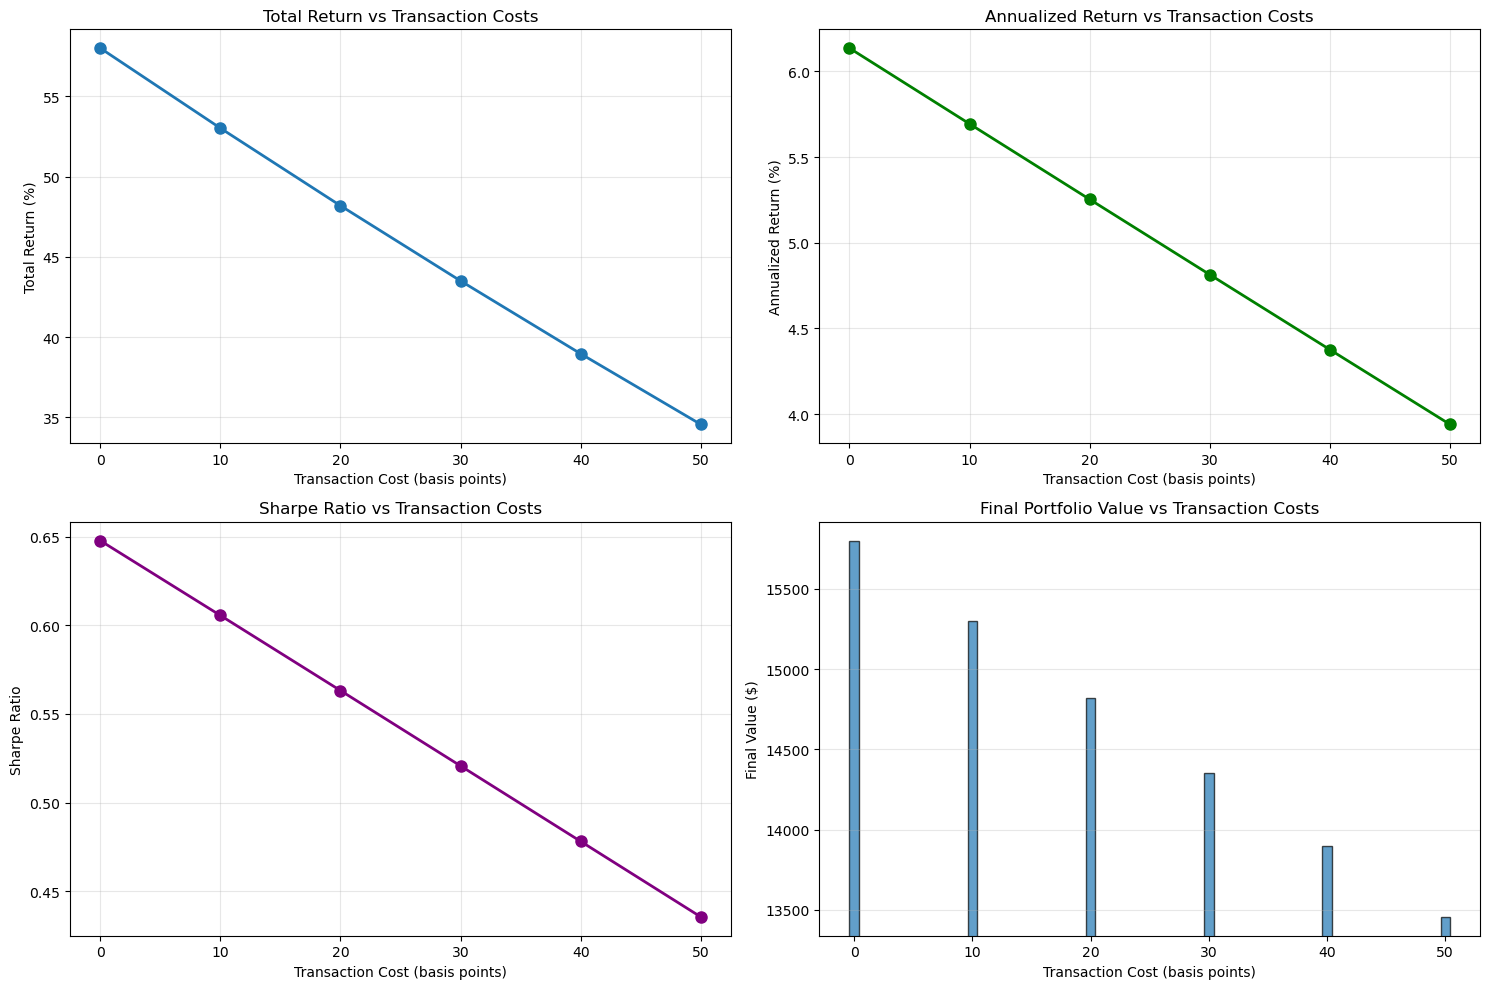

Transaction Cost Sensitivity Analysis
 cost_bps  cost_pct  total_return  annualized_return  sharpe_ratio  final_value
      0.0       0.0      0.580002           0.061350      0.647743 15800.019432
     10.0       0.1      0.530178           0.056933      0.605559 15301.783110
     20.0       0.2      0.481878           0.052529      0.563196 14818.782168
     30.0       0.3      0.435057           0.048140      0.520707 14350.565313
     40.0       0.4      0.389669           0.043764      0.478146 13896.694184
     50.0       0.5      0.345674           0.039403      0.435566 13456.743000


Strategy remains profitable at all tested cost levels


In [66]:
from core_metrics import sensitivity

prices_data = pd.read_csv("../data/processed/training_data_70.csv")

def ma_volatility_filter_helper(investment_amount, test_data, short_ma, long_ma, transaction_costs=0.001, slippage=0.0005):
    res = ma_volatility_filter(investment_amount, test_data, short_ma, long_ma, threshold, transaction_costs, slippage)
    return res
df = sensitivity(ma_volatility_filter_helper, investment_amount, prices_data, short_ma, long_ma)